Using PINNs to approximate the solutions to a simple harmonic oscilator

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [2]:
class PINN(nn.Module):

    def __init__(self, input_size, output_size, n_hidden_layers, hidden_layer_size):
        super().__init__()

        self.input_layer = nn.Linear(input_size, hidden_layer_size)
        self.input_activation = nn.Tanh()

        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_layer_size, hidden_layer_size) if i%2!=0 else nn.Tanh() for i in range(2*n_hidden_layers)])
        self.sequential_module = nn.Sequential(*self.hidden_layers)

        self.output_layer = nn.Linear(hidden_layer_size, output_size)
        
    def forward(self, x):

        x = self.input_layer(x)
        x = self.input_activation(x)

        x = self.sequential_module(x)

        x = self.output_layer(x)
        
        return x


In [3]:
def exact_solution(d, w0, t):
    "Defines the analytical solution to the under-damped harmonic oscillator problem above."
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos
    return u

In [4]:
torch.manual_seed(42)

In [5]:
boundary_points = torch.tensor(0.).view(-1, 1).requires_grad_(True)
boundary_condition = torch.tensor(1.)
boundary_condition_derivative = torch.tensor(0.)

collocation_points = torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True)

In [6]:
model = PINN(1, 1, 3, 32)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
lambda_1 = 1e-1
lambda_2 = 1e-4
d, w0 = 2, 20
mu, k = 2*d, w0**2

test_points = torch.linspace(0, 1, 300).view(-1, 1)
solution = exact_solution(d, w0, test_points)

/home/vitor/physics_ml/env_physics_ml/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


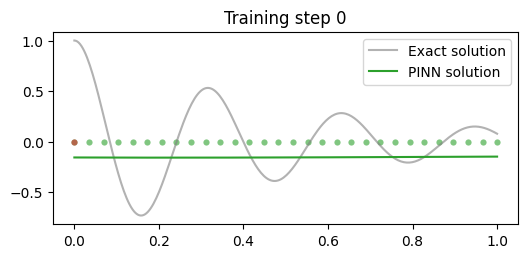

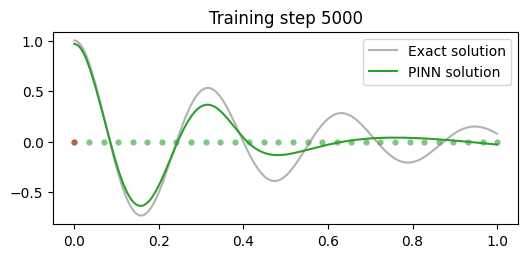

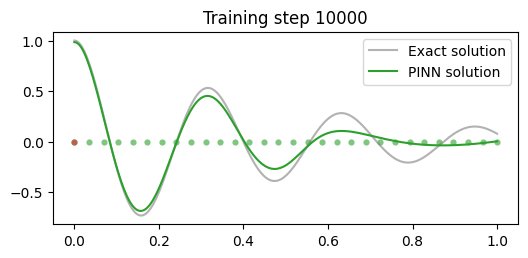

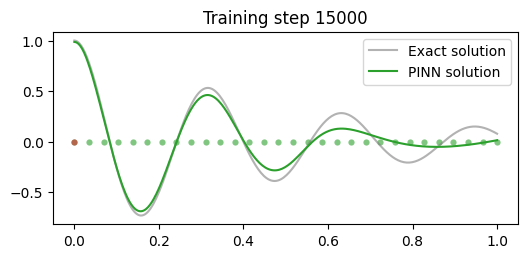

In [7]:
epochs = 15000
mse_loss = nn.MSELoss()
for epoch in range(epochs+1):

    optimizer.zero_grad()

    boundary_output = model(boundary_points)

    boundary_loss = mse_loss(boundary_output, boundary_condition)
    dudt = torch.autograd.grad(boundary_output, boundary_points, torch.ones_like(boundary_output), create_graph=True)[0] #derivative of the output calculated at the boundary points
    boundary_loss_derivative = mse_loss(dudt, boundary_condition_derivative)


    collocation_output = model(collocation_points)

    dudt = torch.autograd.grad(collocation_output, collocation_points, torch.ones_like(collocation_output), create_graph=True)[0] #first order derivative of the system at the collocation points
    du2dt2 = torch.autograd.grad(dudt, collocation_points, torch.ones_like(dudt), create_graph=True)[0] #second order derivative of the systems at the collocation points

    collocation_loss = mse_loss(du2dt2 + mu*dudt + k*collocation_output, torch.zeros_like(collocation_output)) #differential equations should sum to zero

    loss = boundary_loss + lambda_1*boundary_loss_derivative + lambda_2*collocation_loss
    loss.backward()
    optimizer.step()

    if epoch%5000 == 0:
        test_output = model(test_points).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(collocation_points.detach()[:,0], 
                    torch.zeros_like(collocation_points)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(boundary_points.detach()[:,0], 
                    torch.zeros_like(boundary_points)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(test_points[:,0], solution[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(test_points[:,0], test_output[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {epoch}")
        plt.legend()
        plt.show()

